# Probing Syntax in LLMs
by Lars Kulbe, Maxim Kurvink & Ole Jürgensen

#### Import libraries

In [1]:
import os
import requests
import re
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

import transformer_lens
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from io import StringIO, BytesIO
from conllu import parse_incr
from IPython.display import Image, display
from PIL import Image as PILImage


/home/c13745859/anaconda3/envs/syntax_probing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Introduction to Parsing Trees & Dataset

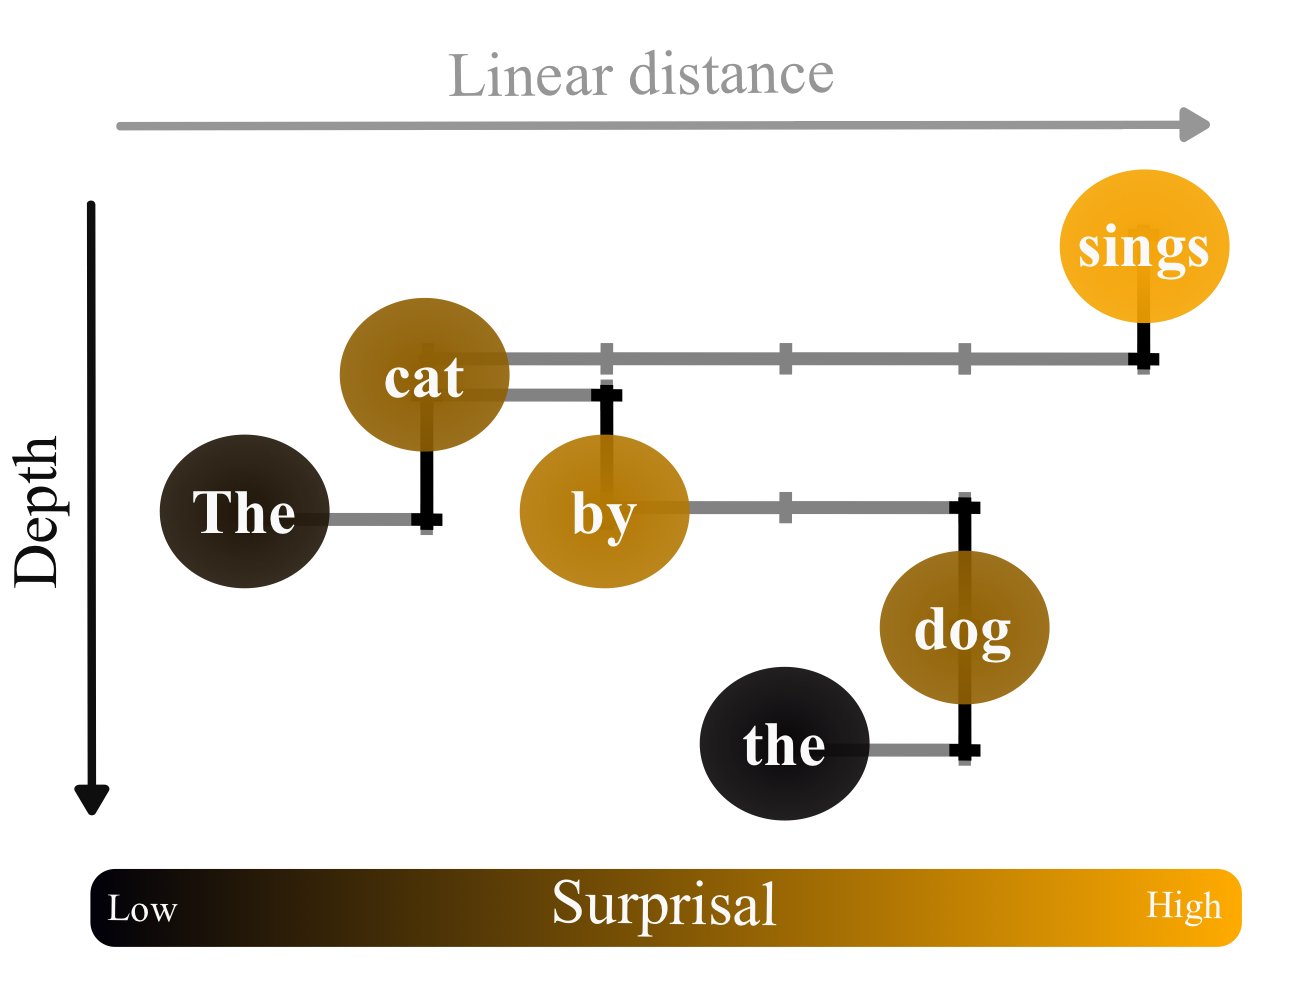

In [2]:
image_path = "images/tree_example.jpeg"
display(Image(filename=image_path, width=400, height=300))

The image adpated from Diego-Simon et al. (2025) depicts a typical **dependency based parse** tree for a short sentence. Nodes in the tree represent words or tokens, and edges represent immediate dependencies. Nodes connecting to a node at the lower level, are referred to as that nodes **parent**, while the lower node is called the **child**. At the lowest depth, we fnd the **root** of the sentence (sings), which will be main verb if the sentence. The children of a node can be thought of as adding information to the parent. In this example, the prepositional phrase "by the dog" modifies the subject "cat".

To construct these trees, we require hand-annoted sentences. We use the Universal Dependencies - English Dependency Treebank (v2.17 -- 2025-11-15) data, which is openly available on their GitHub repository.

In [3]:
def get_data():
    sentences_train = []
    sentences_test = []

    root_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/"
    
    files = {
        "test": "en_ewt-ud-test.conllu", 
        "train": "en_ewt-ud-train.conllu"
        }

    for key, file in files.items():
        file_url = os.path.join(root_url, file)
        response = requests.get(file_url)
        response.raise_for_status()


        file_content = StringIO(response.text)
        for sentence in parse_incr(file_content):
            if key == "test":
                sentences_test.append(sentence)
            if key == "train":
                sentences_train.append(sentence)

    # exlude email addresses and URLs
    email_pattern = re.compile(r'\S+@\S+')
    url_pattern = re.compile(r'http\S+|www\S+')

    sentences_train = [s for s in sentences_train if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    sentences_test =  [s for s in sentences_test  if not email_pattern.search(s.metadata["text"]) and not url_pattern.search(s.metadata["text"])]
    
    return sentences_train, sentences_test

sentences_train, sentences_test = get_data()
print("There are {} training sentences and {} test sentences.".format(len(sentences_train), len(sentences_test)))

There are 12279 training sentences and 2004 test sentences.


Print some example sentences:

In [4]:
for i in np.random.randint(0, len(sentences_train), size = 5):
    print(sentences_train[i].metadata["text"])

It is a time to learn what happened and how it may affect the future.
Thanks!
Bath was clean except shower stall which had mildew problems.
She said it is getting better.
I want to go travelling.


The dependecy tree structure can be decribed by a single variable (head), specifying the **parent** of a given word.

In [5]:
idx = 59
print(sentences_test[idx].metadata["text"])
print("")
for tok in sentences_test[idx]:
    print(str(tok['id']).ljust(3), tok['form'].ljust(12), ' --> ', sentences_test[idx][tok['head']-1]['form'] if tok['head'] != 0 else 'ROOT')

I had to go to the BBC for this report .

1   I             -->  had
2   had           -->  ROOT
3   to            -->  go
4   go            -->  had
5   to            -->  BBC
6   the           -->  BBC
7   BBC           -->  go
8   for           -->  report
9   this          -->  report
10  report        -->  go
11  .             -->  had


Based on this we can reconstruct the parse tree distances using the lowest common ancestor (LCA; not to be confused with Latent Class Analysis). Direct links have a distance of 1, if there is one node sperating, them the distance is 2, and so on.

<Axes: >

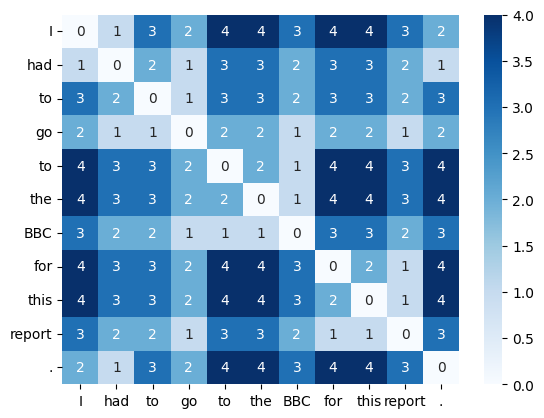

In [6]:
# expand to see function
def distance_matrix_from_sentence(sentence):
    """
    Return (matrix, ids) where matrix[i,j] is the discrete tree distance
    (number of edges) between token ids[i] and ids[j].
    Expects tokens with integer 'id' and 'head' (head==0 means ROOT).
    """

    forms = [tok['form'] for tok in sentence]
    ids = [tok['id'] for tok in sentence if isinstance(tok['id'], int)]
    parent = {tok['id']: (tok['head'] if tok['head'] != 0 else None) for tok in sentence if isinstance(tok['id'], int)}
    
    # Find the root token's id (where head == 0)
    root_id = next(tok['id'] for tok in sentence if isinstance(tok['id'], int) and tok['head'] == 0)
    id_to_idx = {tid: idx for idx, tid in enumerate(ids)}
    root_idx = id_to_idx[root_id]

    def ancestors(n):
        path = [n]
        while parent.get(path[-1]) is not None:
            path.append(parent[path[-1]])
        return path  # from node up to root

    depths = {i: len(ancestors(i)) - 1 for i in ids}  # distance to root
    n = len(ids)
    mat = np.zeros((n, n), dtype=int)

    # compute pairwise distances via lowest common ancestor (LCA)
    for i, a in enumerate(ids):
        anc_a = ancestors(a)
        set_anc_a = set(anc_a)
        for j, b in enumerate(ids):
            if i == j:
                continue
            anc_b = ancestors(b)
            # find first common ancestor when walking from node b up (closest to b)
            lca = next((x for x in anc_b if x in set_anc_a), None)
            mat[i, j] = depths[a] + depths[b] - 2 * depths[lca]

    root_dist = mat[root_idx, :]
    return mat, ids, root_dist, forms


mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[idx])
sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True)

We can transfrom the distance matrix into a dependency based parsing tree using the networkx library. We obtain the minimum spanning tree through Kruskal's algorithm. Note that we manually set the node positions by their order in the sentence (x-axis) and their distance from the root (i.e. depth; y-axis).

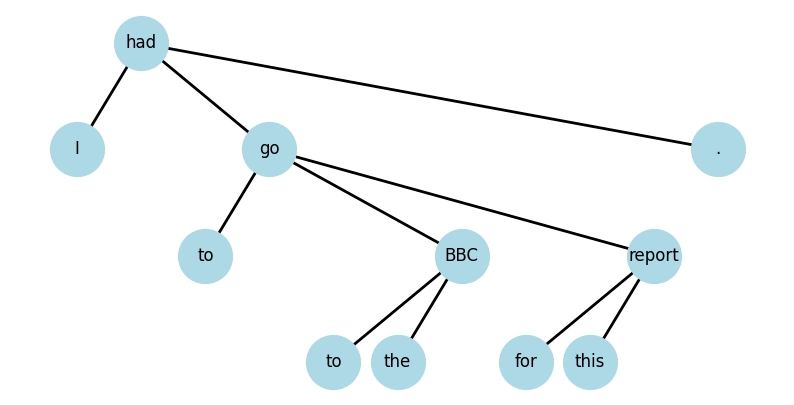

In [7]:
def graph_from_distance_matrix(mat, ids, root_dist, forms, ax=None, node_size = 1500, font_size = 12, width = 2):

    # Compute MST using Kruskal’s algorithm
    G = nx.from_numpy_array(mat)
    mst = nx.minimum_spanning_tree(G, algorithm="kruskal")
    # get adjacency matrix
    adj_matrix = nx.to_numpy_array(mst)
    # Prepare node positions: x=ids, y=root_dist
    pos = {i: (id, len(root_dist) - root_dist[idx]) for idx, (i, id) in enumerate(zip(range(len(ids)), ids))}

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    nx.draw(
        mst,
        pos=pos,
        ax=ax,
        with_labels=True,
        labels={i: forms[i] for i in range(len(forms))},
        node_color='lightblue',
        edge_color='black',
        node_size=node_size,
        font_size=font_size,
        width=width,
    )
    ax.set_xlabel("ids")
    ax.set_ylabel("root_dist")

    return adj_matrix, ax

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs)
plt.show()

Lets do this for some more sentences:

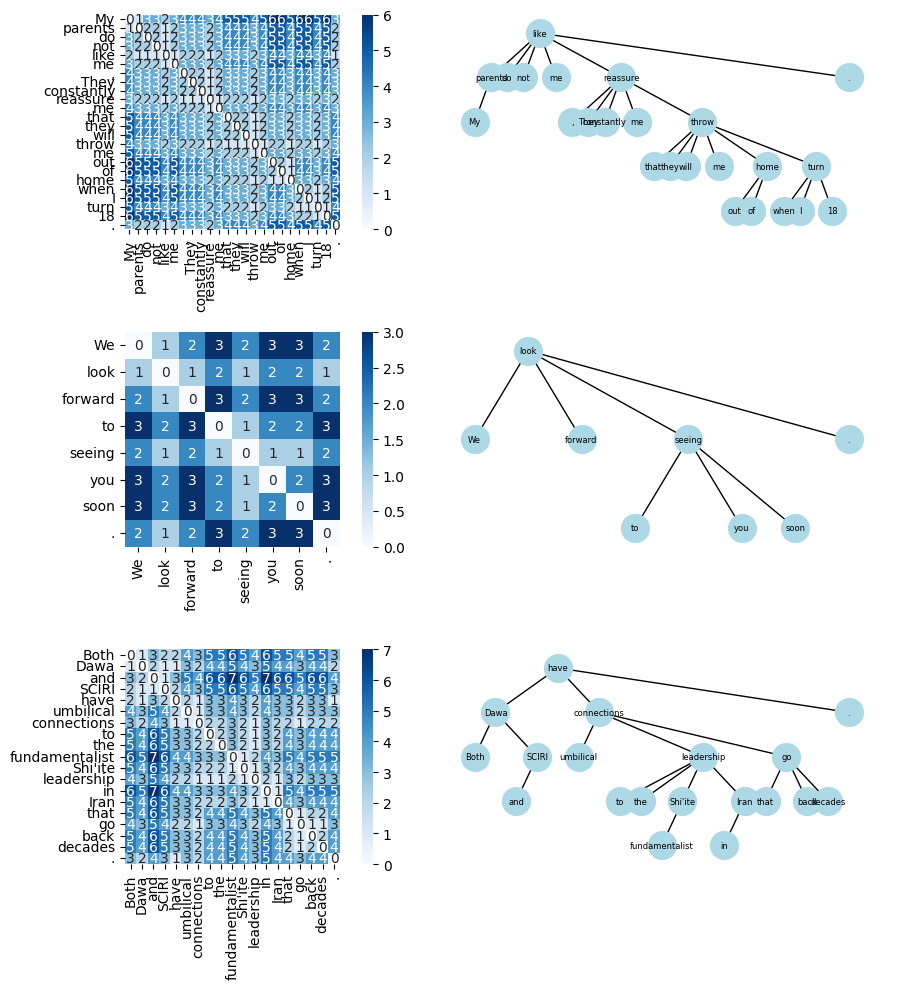

In [8]:
num_sentences = 3
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

np.random.seed(2) # note that the sentences can be quite long, if the seed is changed
for i, id in enumerate(np.random.randint(0, len(sentences_train), size = num_sentences)):
    mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_train[id])
    sns.heatmap(mat, xticklabels=forms, yticklabels=forms, cmap="Blues", annot=True, ax = axs[i, 0], square =True)
    graph_from_distance_matrix(mat, ids, root_dist, forms, ax=axs[i, 1], node_size = 400, font_size = 6, width = 1)
plt.tight_layout()

## Research Question

Our goal is to evaluate the syntactic knowledge of a large language model (LLM), by testing how well its hidden states encode this parse tree.

## Load Train (choo chooo)

Create the training and test data set.

In [9]:
sentences_train, sentences_test = get_data()

In [10]:
# create val split
val_idx = np.random.randint(0, len(sentences_train), size = int(0.1 * len(sentences_train)))
sentences_val = [sentences_train[i] for i in val_idx]
sentences_train = [sentences_train[i] for i in range(len(sentences_train)) if i not in val_idx]

len(sentences_train), len(sentences_val), len(sentences_test)

(11107, 1227, 2004)

In [11]:
def get_activations(sentences, model_name, layer_name, batch_size=16):
    """function to get activations from a specific layer for a list of sentences"""
    # take sentences as list of strings
    sentences = [s.metadata["text"] for s in sentences]
    # load model
    model = transformer_lens.HookedTransformer.from_pretrained(model_name)
    # extract activations
    all_activations = []
    seq_lens = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        _, activations = model.run_with_cache(batch)
        batch_activations = activations[layer_name].cpu().numpy()
        all_activations.append(batch_activations)
        seq_lens.append(batch_activations.shape[1])
        torch.cuda.empty_cache()
    # Find the true max length across all batches
    max_length = max(seq_lens)
    # Pad all batches to max_length
    padded_activations = []
    for batch_activations in all_activations:
        pad_width = max_length - batch_activations.shape[1]
        if pad_width > 0:
            batch_activations = np.pad(batch_activations, ((0,0),(0,pad_width),(0,0)), mode='constant', constant_values=0)
        padded_activations.append(batch_activations)
    return np.concatenate(padded_activations, axis=0)

#activations_train = get_activations(sentences_train, 'gpt2-small', 'blocks.8.hook_resid_post', batch_size=8)
#activations_train.shape

In [12]:
def get_matrices(sentences):
    matrices = []
    for sent in sentences:
        mat, _, _, _ = distance_matrix_from_sentence(sent)
        matrices.append(mat)
    return matrices
matrices_train = get_matrices(sentences_train)
#len(matrices_train)

In [ ]:
class SyntaxProbeDataset(Dataset):
    def __init__(self, sentences, model_name, layer_name):
        self.sentences = []
        self.activations = []
        self.matrices = []
        model = transformer_lens.HookedTransformer.from_pretrained(model_name)
        for sentence in tqdm(sentences, desc="Processing sentences"):
            text = sentence.metadata["text"]
            _, activations = model.run_with_cache([text])
            activation = activations[layer_name].cpu().numpy()[0]
            mat, _, _, _ = distance_matrix_from_sentence(sentence)
            if activation.shape[0] == mat.shape[0]:
                self.sentences.append(sentence)
                self.activations.append(activation)
                self.matrices.append(mat)
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self, idx):
        return self.activations[idx], self.matrices[idx]
    

def custom_collate_fn(batch):
    # batch: list of (activation, matrix) tuples
    activations, matrices = zip(*batch)
    batch_size = len(activations)
    seq_lens = [a.shape[0] for a in activations]
    max_len = max(seq_lens)
    hidden_dim = activations[0].shape[1]

    # Pad activations
    padded_activations = np.zeros((batch_size, max_len, hidden_dim), dtype=np.float32)
    for i, act in enumerate(activations):
        padded_activations[i, :act.shape[0], :] = act

    # Pad matrices
    padded_matrices = np.full((batch_size, max_len, max_len), fill_value=-1, dtype=np.float32)
    for i, mat in enumerate(matrices):
        l = mat.shape[0]
        padded_matrices[i, :l, :l] = mat

    # Convert to torch tensors
    padded_activations = torch.tensor(padded_activations)
    padded_matrices = torch.tensor(padded_matrices)
    lengths = torch.tensor(seq_lens)

    return padded_activations, padded_matrices, lengths, None


#dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', 'blocks.8.hook_resid_post')
#dataloader = DataLoader(dataset, batch_size=8, collate_fn=custom_collate_fn)

## Implement Deep Learning

In [14]:
class Probe(nn.Module):
  pass

class TwoWordPSDProbe(Probe):
  """ Computes squared L2 distance after projection by a matrix.

  For a batch of sentences, computes all n^2 pairs of distances
  for each sentence in the batch.
  """
  def __init__(self, args):
    print('Constructing TwoWordPSDProbe')
    super(TwoWordPSDProbe, self).__init__()
    self.args = args
    self.probe_rank = args['probe']['maximum_rank']
    self.model_dim = args['model']['hidden_dim']

    # Initialize projection matrix
    self.proj = nn.Parameter(data = torch.zeros(self.model_dim, self.probe_rank))
    nn.init.uniform_(self.proj, -0.05, 0.05)
    self.to(args['device'])

  def forward(self, batch):
    """ Computes all n^2 pairs of distances after projection
    for each sentence in a batch.

    Note that due to padding, some distances will be non-zero for pads.
    Computes (B(h_i-h_j))^T(B(h_i-h_j)) for all i,j

    Args:
      batch: a batch of word representations of the shape
        (batch_size, max_seq_len, representation_dim)
    Returns:
      A tensor of distances of shape (batch_size, max_seq_len, max_seq_len)
    """
    batch = batch.to(self.proj.device) # added

    transformed = torch.matmul(batch, self.proj)
    batchlen, seqlen, rank = transformed.size()
    transformed = transformed.unsqueeze(2)
    transformed = transformed.expand(-1, -1, seqlen, -1)
    transposed = transformed.transpose(1,2).to(self.proj.device)
    diffs = transformed - transposed
    squared_diffs = diffs.pow(2).to(self.proj.device)
    squared_distances = torch.sum(squared_diffs, -1)
    return squared_distances

In [15]:
class L1DistanceLoss(nn.Module):
  """Custom L1 loss for distance matrices."""
  def __init__(self, args):
    super(L1DistanceLoss, self).__init__()
    self.args = args
    self.word_pair_dims = (1,2)

  def forward(self, predictions, label_batch, length_batch):
    """ Computes L1 loss on distance matrices.

    Ignores all entries where label_batch=-1
    Normalizes first within sentences (by dividing by the square of the sentence length)
    and then across the batch.

    Args:
      predictions: A pytorch batch of predicted distances
      label_batch: A pytorch batch of true distances
      length_batch: A pytorch batch of sentence lengths

    Returns:
      A tuple of:
        batch_loss: average loss in the batch
        total_sents: number of sentences in the batch
    """
    device = predictions.device
    label_batch = label_batch.to(device)
    length_batch = length_batch.to(device)

    labels_1s = (label_batch != -1).float()
    predictions_masked = predictions * labels_1s
    labels_masked = label_batch * labels_1s
    total_sents = torch.sum((length_batch != 0)).float()
    squared_lengths = length_batch.pow(2).float()
    if total_sents > 0:
      loss_per_sent = torch.sum(torch.abs(predictions_masked - labels_masked), dim=self.word_pair_dims)
      normalized_loss_per_sent = loss_per_sent / squared_lengths
      batch_loss = torch.sum(normalized_loss_per_sent) / total_sents
    else:
      batch_loss = torch.tensor(0.0, device=self.args['device'])
    return batch_loss, total_sents


In [16]:
"""Classes for training and running inference on probes."""
import os
import sys

from torch import optim
import torch
from tqdm import tqdm

class ProbeRegimen:
  """Basic regimen for training and running inference on probes.
  
  Tutorial help from:
  https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

  Attributes:
    optimizer: the optimizer used to train the probe
    scheduler: the scheduler used to set the optimizer base learning rate
  """

  def __init__(self, args):
    self.args = args
    self.max_epochs = args['probe_training']['epochs']
    self.params_path = os.path.join(args['reporting']['root'], args['probe']['params_path'])

  def set_optimizer(self, probe):
    """Sets the optimizer and scheduler for the training regimen.
  
    Args:
      probe: the probe PyTorch model the optimizer should act on.
    """
    self.optimizer = optim.Adam(probe.parameters(), lr=0.001)
    self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1,patience=0)

  def train_until_convergence(self, probe, model, loss, train_dataset, dev_dataset):
    """ Trains a probe until a convergence criterion is met.

    Trains until loss on the development set does not improve by more than epsilon
    for 5 straight epochs.

    Writes parameters of the probe to disk, at the location specified by config.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      loss: An instance of loss.Loss, computing loss between predictions and labels
      train_dataset: a torch.DataLoader object for iterating through training data
      dev_dataset: a torch.DataLoader object for iterating through dev data
    """
    self.set_optimizer(probe)
    min_dev_loss = sys.maxsize
    min_dev_loss_epoch = -1

    self.train_losses = []
    self.val_losses = []
    
    for epoch_index in tqdm(range(self.max_epochs), desc='[training]'):
      epoch_train_loss = 0
      epoch_dev_loss = 0
      epoch_train_epoch_count = 0
      epoch_dev_epoch_count = 0
      epoch_train_loss_count = 0
      epoch_dev_loss_count = 0
      for batch in tqdm(train_dataset, desc='[training batch]'):
        probe.train()
        self.optimizer.zero_grad()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        batch_loss.backward()
        epoch_train_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_train_epoch_count += 1
        epoch_train_loss_count += count.detach().cpu().numpy()
        self.optimizer.step()
      for batch in tqdm(dev_dataset, desc='[dev batch]'):
        self.optimizer.zero_grad()
        probe.eval()
        observation_batch, label_batch, length_batch, _ = batch
        word_representations = model(observation_batch)
        predictions = probe(word_representations)
        batch_loss, count = loss(predictions, label_batch, length_batch)
        epoch_dev_loss += batch_loss.detach().cpu().numpy()*count.detach().cpu().numpy()
        epoch_dev_loss_count += count.detach().cpu().numpy()
        epoch_dev_epoch_count += 1


      # Compute average losses and store them
      avg_train_loss = epoch_train_loss / epoch_train_loss_count
      avg_dev_loss = epoch_dev_loss / epoch_dev_loss_count
      self.train_losses.append(avg_train_loss)
      self.val_losses.append(avg_dev_loss)
        
      self.scheduler.step(epoch_dev_loss)
      tqdm.write('[epoch {}] Train loss: {}, Dev loss: {}'.format(epoch_index, epoch_train_loss/epoch_train_loss_count, epoch_dev_loss/epoch_dev_loss_count))
      if epoch_dev_loss / epoch_dev_loss_count < min_dev_loss - 0.0001:
        torch.save(probe.state_dict(), self.params_path)
        min_dev_loss = epoch_dev_loss / epoch_dev_loss_count
        min_dev_loss_epoch = epoch_index
        tqdm.write('Saving probe parameters')
      elif min_dev_loss_epoch < epoch_index - 4:
        tqdm.write('Early stopping')
        break

  def predict(self, probe, model, dataset):
    """ Runs probe to compute predictions on a dataset.

    Args:
      probe: An instance of probe.Probe, transforming model outputs to predictions
      model: An instance of model.Model, transforming inputs to word reprs
      dataset: A pytorch.DataLoader object 

    Returns:
      A list of predictions for each batch in the batches yielded by the dataset
    """
    probe.eval()
    predictions_by_batch = []
    for batch in tqdm(dataset, desc='[predicting]'):
      observation_batch, label_batch, length_batch, _ = batch
      word_representations = model(observation_batch)
      predictions = probe(word_representations)
      predictions_by_batch.append(predictions.detach().cpu().numpy())
    return predictions_by_batch

In [ ]:
args = {
    'probe': {'maximum_rank': 64, 'params_path': 'probe_params.pt'},
    'model': {'hidden_dim': 768},
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'probe_training': {'epochs': 100},
    'reporting': {'root': './'}
}
probe = TwoWordPSDProbe(args)
loss_fn = L1DistanceLoss(args)
regimen = ProbeRegimen(args)

dataset = SyntaxProbeDataset(sentences_train, 'gpt2-small', 'blocks.8.hook_resid_post')
dataloader = DataLoader(dataset, batch_size=8, collate_fn=custom_collate_fn)

val_dataset = SyntaxProbeDataset(sentences_val, 'gpt2-small', 'blocks.8.hook_resid_post')
val_dataloader = DataLoader(val_dataset, batch_size=8, collate_fn=custom_collate_fn)

class IdentityModel(nn.Module):
    def forward(self, x):
        return x
model = IdentityModel()

Constructing TwoWordPSDProbe
Loaded pretrained model gpt2-small into HookedTransformer


Processing sentences:  16%|█▌        | 1780/11107 [01:02<04:39, 33.34it/s]

In [ ]:
regimen.train_until_convergence(
    probe=probe,
    model=model,
    loss=loss_fn,
    train_dataset=dataloader,
    dev_dataset=val_dataloader
)

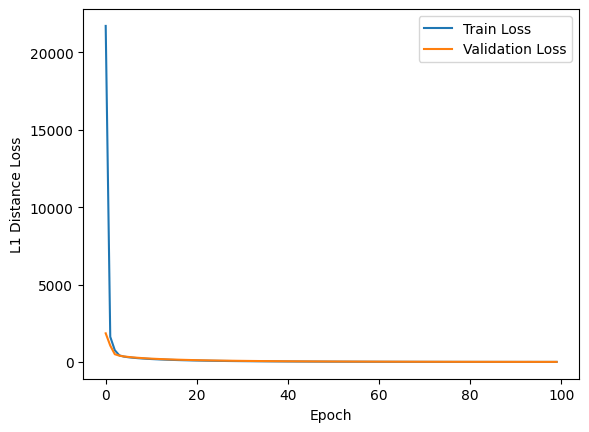

In [90]:
plt.plot(regimen.train_losses, label='Train Loss')
plt.plot(regimen.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('L1 Distance Loss')
plt.legend()

In [91]:
regimen.val_losses

[1849.8626206341912,
 1058.4687930836396,
 499.2239990234375,
 407.019333783318,
 357.1935999253217,
 322.83046946806064,
 294.5138208725873,
 270.4811814252068,
 249.59875129250918,
 231.22580225327437,
 214.92373118681067,
 200.33875409294578,
 187.20319321576287,
 175.30985215130974,
 164.49659639246323,
 154.6247397030101,
 145.57760620117188,
 137.2588159897748,
 129.58746068617876,
 122.49480662626378,
 115.92161245907054,
 109.81652113970588,
 104.13470818014706,
 98.83686290067784,
 93.88833348891315,
 89.25858980066636,
 84.92034463321461,
 80.84926470588235,
 77.02292139389935,
 73.42333670223461,
 70.03181278004365,
 66.83313302432789,
 63.813185299144074,
 60.95899694106158,
 58.25886221492992,
 55.70202771355124,
 53.278390772202435,
 50.97920227050781,
 48.796498466940484,
 46.72269955803366,
 44.75071985581342,
 42.874794230741614,
 41.0876942802878,
 39.38529923382927,
 37.76262305764591,
 36.21534751443302,
 34.73870759851792,
 33.32931361478918,
 31.983591640696805,
 

In [86]:
# Prepare your new sentences as a SyntaxProbeDataset and DataLoader
novel_sentences = sentences_test

novel_dataset = SyntaxProbeDataset(novel_sentences, 'gpt2-small', 'blocks.8.hook_resid_post')
novel_dataloader = DataLoader(novel_dataset, batch_size = 20, collate_fn=custom_collate_fn)

# Make predictions
predictions = regimen.predict(probe, model, novel_dataloader)

Loaded pretrained model gpt2-small into HookedTransformer


[predicting]: 100%|██████████| 2/2 [00:00<00:00, 42.50it/s]


In [87]:
print(len(predictions))
print(predictions[0].shape)

2
(20, 81, 81)


What if Google Morphed Into GoogleOS?


<Axes: >

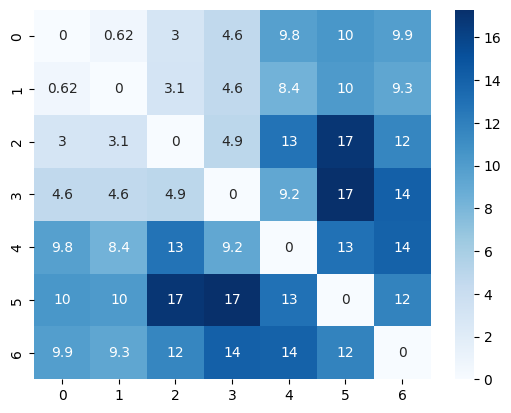

In [88]:
sentence_idx = 0
mat, ids, root_dist, forms = distance_matrix_from_sentence(sentences_test[sentence_idx])
sentence = novel_sentences[sentence_idx]
print(sentence.metadata["text"])
sns.heatmap(predictions[0][sentence_idx][:len(sentence), :len(sentence)], 
            cmap = "Blues", annot = True)

## References